In [59]:
import tensorflow as tf

def ExtractRoiForPrediction(image):
    x=0.3
    target_width=int(640*x)
    target_height=int(480*x)
    offset_width=(640-target_width)//2
    offset_height=(480-target_height)//2
    return tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)

class FusedModel(tf.Module):
  def __init__(self):
    self.color_classifier = tf.saved_model.load('/nfs/general/shared/tf_models/color_classifier')
    self.orientation_classifier=tf.saved_model.load('/nfs/general/shared/tf_models/orientation')

  @tf.function(input_signature=[tf.TensorSpec(shape=[480,640,3], dtype=tf.uint8)])
  def compute(self, image):
    image_cropped_for_color = tf.cast(ExtractRoiForPrediction(image), tf.float32)[tf.newaxis,:,:,:]
    image_for_position_detection = tf.image.convert_image_dtype(tf.image.rgb_to_grayscale(tf.image.crop_to_bounding_box(image, 220,70,100,500)), tf.float32)[tf.newaxis,:,:,:]
    orientation=self.orientation_classifier(image_for_position_detection)[0,:]
    return tf.math.softmax(self.color_classifier(image_cropped_for_color))[0,:], orientation


model = FusedModel()
tf.saved_model.save(model, '/tmp/adder')

converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/adder') 

converter.optimizations = [tf.lite.Optimize.DEFAULT]
def ReadImage(filename):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image.set_shape([480,640,3])
  return image

def representative_dataset():
  for data in tf.data.Dataset.list_files('/nfs/general/shared/Key*/*.jpg').shuffle(buffer_size=10000).take(2000).map(ReadImage):
    yield [tf.dtypes.cast(data, tf.uint8)]

converter.representative_dataset = representative_dataset

tflite_model = converter.convert()
open('/nfs/general/shared/tflite/fused_model.tflite', 'wb').write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/adder/assets


2022-04-23 20:47:44.575722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-23 20:47:44.575753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-23 20:47:44.575921: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/adder
2022-04-23 20:47:44.579004: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-23 20:47:44.579014: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/adder
2022-04-23 20:47:44.585567: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-23 20:47:44.668126: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/adder
2022-04-23 20:47:44.704346: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 128426 microseconds.
2022

Estimated count of arithmetic ops: 83.412 M  ops, equivalently 41.706 M  MACs
Estimated count of arithmetic ops: 83.412 M  ops, equivalently 41.706 M  MACs


fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0
2022-04-23 20:48:26.418107: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 83.412 M  ops, equivalently 41.706 M  MACs



166480

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

[0.10662718 0.8619031 ] [0.  0.  0.  0.  0.  0.5 0.5]
white


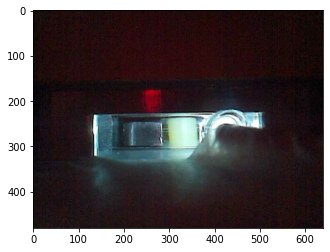

In [60]:
import numpy as np
import tensorflow as tf


# dataset = tf.data.Dataset.list_files('/nfs/general/shared/Key*/*.jpg').shuffle(buffer_size=10000).take(100).map(ReadImage)


# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='/nfs/general/shared/tflite/fused_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
# input_data = next(iter(dataset)) #np.array(np.random.random_sample(input_shape), dtype=np.uint8)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data2 = interpreter.get_tensor(output_details[1]['index'])
print(output_data,output_data2)
from matplotlib import pyplot as plt
plt.imshow(input_data)

labels = ['black',
'blue',
'green',
'pink',
'salmon',
'white',
'yellow']

print(labels[np.argmax(output_data2)])


In [42]:
!ls -la /nfs/general/shared/tflite/fused_model.tflite

-rw-rw-r-- 1 geli geli 166480 Apr 23 20:45 /nfs/general/shared/tflite/fused_model.tflite


In [ ]:
import tensorflow as tf

class FusedModel(tf.Module):
  def __init__(self):
    self.color_classifier = tf.saved_model.load('/nfs/general/shared/tf_models/color_classifier')
    self.orientation_classifier=tf.saved_model.load('/nfs/general/shared/tf_models/orientation')

  @tf.function(input_signature=[tf.TensorSpec(shape=[480,640,3], dtype=tf.uint8)])
  def compute(self, image):
    image_cropped_for_color = tf.image.convert_image_dtype(tf.image.crop_to_bounding_box(image, 220, 260, 40, 80), tf.float32)[tf.newaxis,:,:,:]
    image_for_position_detection = tf.image.convert_image_dtype(tf.image.rgb_to_grayscale(tf.image.crop_to_bounding_box(image, 220,70,100,500)), tf.float32)[tf.newaxis,:,:,:]
    orientation=self.orientation_classifier(image_for_position_detection)[0,:]
    return tf.math.softmax(self.color_classifier(image_cropped_for_color))[0,:], orientation


model = FusedModel()

image = tf.io.decode_jpeg(tf.io.read_file('/nfs/general/shared/KeyD/1650406299896.jpg'))

model.compute(image)

In [ ]:
import glob
BASE_DIR = '/nfs/general/shared'
D_FILES = set([x.replace(BASE_DIR, '')
               for x in glob.glob('{}/KeyD/*.jpg'.format(BASE_DIR))])

In [ ]:
sorted(D_FILES)